#Loading and Cleaning the Dataset

Import libraries

In [ ]:
pip install numpy==1.24.4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Revenue Forecasting/data.csv', encoding='latin1')

Basic cleaning

In [ ]:
df.dropna(subset=['InvoiceNo', 'InvoiceDate', 'CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Aggregate revenue by time

In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].dt.to_timestamp()

Plot baseline trend

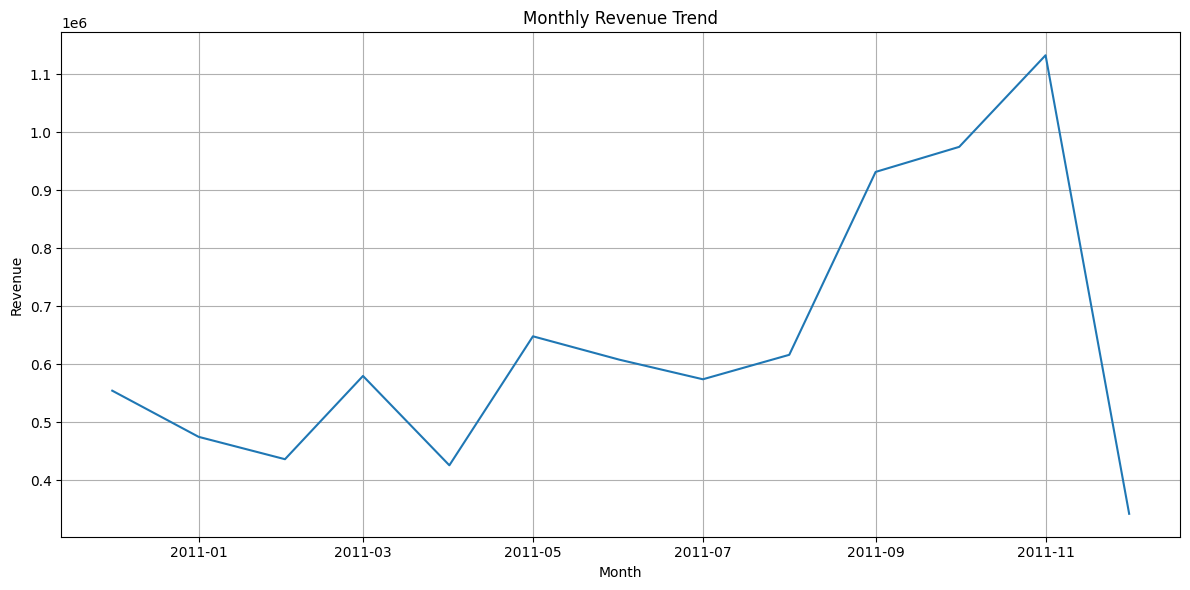

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x='InvoiceMonth', y='TotalPrice', data=monthly_revenue)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

# STL Decomposition and Prophet Model Training

STL Decomposition (Seasonal-Trend-Residual)

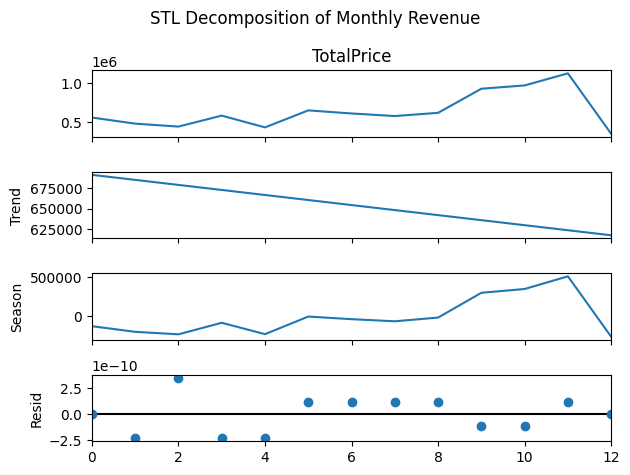

In [ ]:
from statsmodels.tsa.seasonal import STL

# STL decomposition on monthly revenue
stl = STL(monthly_revenue['TotalPrice'], period=12)
result = stl.fit()

# Plot STL
result.plot()
plt.suptitle('STL Decomposition of Monthly Revenue')
plt.tight_layout()
plt.show()

Prophet Forecasting

In [ ]:
!pip install prophet
from prophet import Prophet

In [ ]:
# Rename for Prophet format
df_prophet = monthly_revenue.rename(columns={'InvoiceMonth': 'ds', 'TotalPrice': 'y'})

In [ ]:
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn27xgx88/bay1je4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn27xgx88/7c6zal51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64962', 'data', 'file=/tmp/tmpn27xgx88/bay1je4o.json', 'init=/tmp/tmpn27xgx88/7c6zal51.json', 'output', 'file=/tmp/tmpn27xgx88/prophet_modeljjg9kflk/prophet_model-20250531215701.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:57:01 - cmdstanpy - INFO - Chain [1] start processing
IN

In [ ]:
future = model.make_future_dataframe(periods=6, freq='M')  # Forecast next 6 months
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


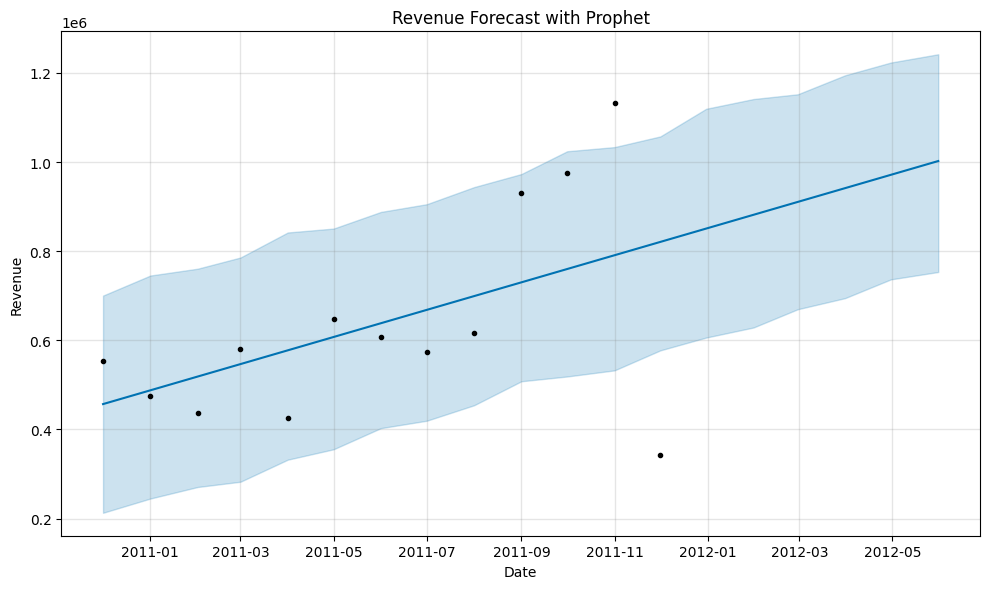

In [ ]:
fig = model.plot(forecast)
plt.title('Revenue Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Align forecast with actuals
df_merge = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='left')
actual = df_merge['y'].dropna()
predicted = df_merge['yhat'].dropna()

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 143165.96
RMSE: 194305.38
MAPE: 25.77%


###Save Model for Dashboard

In [ ]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/Portfolio X/Revenue Forecasting/models/prophet_model.pkl')


['/content/drive/MyDrive/Portfolio X/Revenue Forecasting/models/prophet_model.pkl']

#ARIMA/SARIMA Forecasting

Install and Import pmdarima (Auto-ARIMA)

In [ ]:
!pip install pmdarima
import pmdarima as pm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00


 Prepare the Series

In [ ]:
# Ensure index is datetime for ARIMA
monthly_revenue_arima = monthly_revenue.set_index('InvoiceMonth')['TotalPrice']

Find the Best ARIMA Model

In [ ]:
model_arima = pm.auto_arima(monthly_revenue_arima, seasonal=False, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_arima.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=373.368, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=387.954, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=366.575, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=379.723, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=367.917, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=368.239, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=369.825, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=362.208, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=361.331, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=362.515, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=364.734, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.643 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   13
Model:                        SARIMAX   Log Likelihood                -178.666
Date:                Sat, 31 May 2025   AIC                            361.331
Time:                        21:57:20   BIC                            362.461
Sample:                    12-01-2010   HQIC                           361.099
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
int

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Forecast Future Periods

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-18-73ea7dd68430>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(monthly_revenue_arima.index[-1] + pd.offsets.MonthBegin(), periods=n_periods, freq='M')


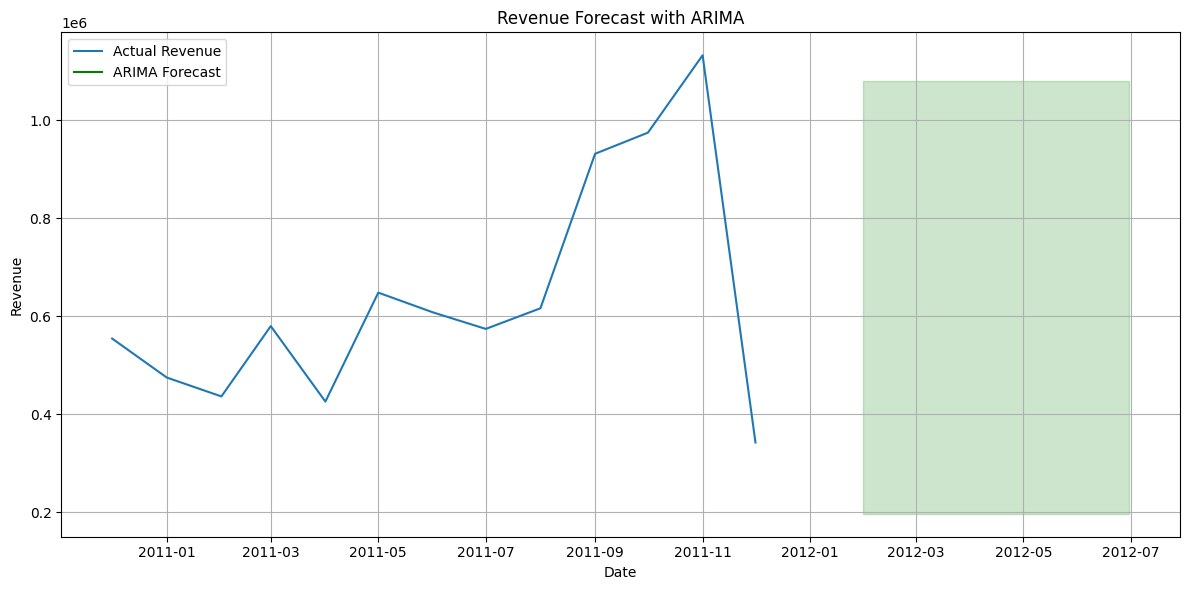

In [ ]:
n_periods = 6  # Next 6 months
forecast_arima, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(monthly_revenue_arima.index[-1] + pd.offsets.MonthBegin(), periods=n_periods, freq='M')
forecast_series = pd.Series(forecast_arima, index=forecast_index)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_revenue_arima, label='Actual Revenue')
plt.plot(forecast_series, label='ARIMA Forecast', color='green')
plt.fill_between(forecast_index, confint[:,0], confint[:,1], color='green', alpha=0.2)
plt.title('Revenue Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluate ARIMA Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Forecast into future periods
n_periods = 6
forecast_arima, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(monthly_revenue_arima.index[-1] + pd.offsets.MonthBegin(), periods=n_periods, freq='M')
forecast_series = pd.Series(forecast_arima, index=forecast_index)

# Create a DataFrame for comparison
arima_forecast_df = pd.DataFrame({'ds': forecast_index, 'yhat': forecast_arima})

# Merge with actuals (if actuals are available for forecast periods)
actuals_future = monthly_revenue_arima.reindex(forecast_index)

# Drop any rows where actuals are missing
valid_idx = actuals_future.dropna().index
if not valid_idx.empty:
    actuals_eval = actuals_future.loc[valid_idx]
    pred_eval = arima_forecast_df.set_index('ds').loc[valid_idx]['yhat']

    # Calculate metrics
    mae_arima = mean_absolute_error(actuals_eval, pred_eval)
    rmse_arima = np.sqrt(mean_squared_error(actuals_eval, pred_eval))
    mape_arima = np.mean(np.abs((actuals_eval - pred_eval) / actuals_eval)) * 100

    print(f"ARIMA MAE: {mae_arima:.2f}")
    print(f"ARIMA RMSE: {rmse_arima:.2f}")
    print(f"ARIMA MAPE: {mape_arima:.2f}%")
else:
    print("No actual data available for forecast evaluation.")


No actual data available for forecast evaluation.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-19-166d782b1215>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(monthly_revenue_arima.index[-1] + pd.offsets.MonthBegin(), periods=n_periods, freq='M')


#Promotional Impact Analysis

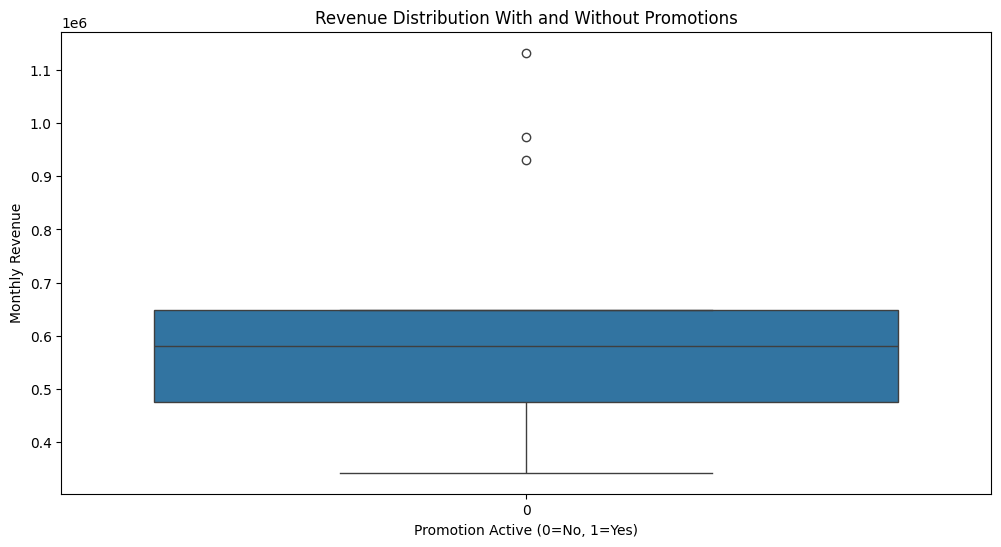

Estimated revenue impact per active promotion month: 0.00
Intercept (base revenue): 638466.60


In [ ]:
monthly_revenue['DiscountRate'] = 0
promo_mask = monthly_revenue['TotalPrice'] > monthly_revenue['TotalPrice'].quantile(0.75)

monthly_revenue['PromoActive'] = (monthly_revenue['DiscountRate'] > 0).astype(int)

plt.figure(figsize=(12,6))
sns.boxplot(x='PromoActive', y='TotalPrice', data=monthly_revenue)
plt.title('Revenue Distribution With and Without Promotions')
plt.xlabel('Promotion Active (0=No, 1=Yes)')
plt.ylabel('Monthly Revenue')
plt.show()

from sklearn.linear_model import LinearRegression

X = monthly_revenue[['PromoActive']]
y = monthly_revenue['TotalPrice']
model_promo = LinearRegression()
model_promo.fit(X, y)

print(f"Estimated revenue impact per active promotion month: {model_promo.coef_[0]:.2f}")
print(f"Intercept (base revenue): {model_promo.intercept_:.2f}")

#Dynamic Pricing Simulation Code

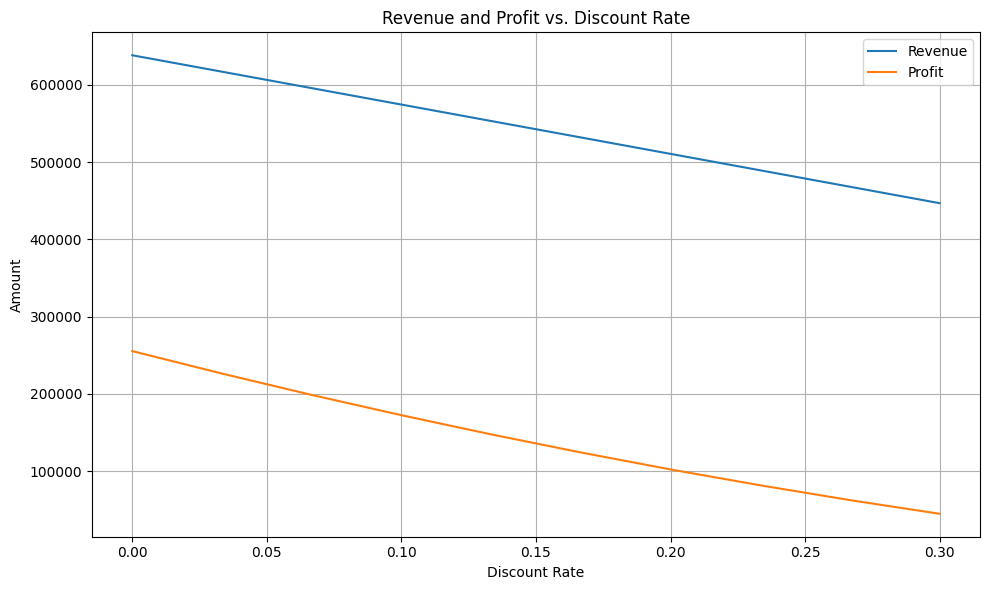

In [ ]:
base_revenue = monthly_revenue['TotalPrice'].mean()
base_margin = 0.4

# Discount rates from 0% to 30%
discount_rates = np.linspace(0, 0.3, 10)

# Initialize lists for simulated revenue and profit
simulated_revenue = []
simulated_profit = []

for dr in discount_rates:
    # Revenue drops with discount rate
    revenue = base_revenue * (1 - dr)
    # Profit adjusts for reduced margin
    profit = revenue * (base_margin - dr)
    simulated_revenue.append(revenue)
    simulated_profit.append(profit)

simulation_df = pd.DataFrame({
    'DiscountRate': discount_rates,
    'SimulatedRevenue': simulated_revenue,
    'SimulatedProfit': simulated_profit
})

plt.figure(figsize=(10,6))
plt.plot(simulation_df['DiscountRate'], simulation_df['SimulatedRevenue'], label='Revenue')
plt.plot(simulation_df['DiscountRate'], simulation_df['SimulatedProfit'], label='Profit')
plt.title('Revenue and Profit vs. Discount Rate')
plt.xlabel('Discount Rate')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Load original data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Revenue Forecasting/data.csv', encoding='latin1', parse_dates=['InvoiceDate'])

# Step 2: Data cleaning and calculations
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()

# Step 3: Aggregate monthly revenue
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()

# Optional: Add PromoActive and DiscountRate if needed
# For demo purposes, we'll assume no promotions
monthly_revenue['PromoActive'] = 0
monthly_revenue['DiscountRate'] = 0.0

# Step 4: Save to CSV for dashboard
monthly_revenue.to_csv('/content/drive/MyDrive/Colab Notebooks/Revenue Forecasting/monthly_revenue.csv', index=False)